In [1]:
import numpy as np
import os
import cv2
import random

from os.path import join as pjoin
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def generator(path,
              size=256,
              crop_size=32,
              is_test=False):
    image_paths = [pjoin(path, img_path) for img_path in os.listdir(path)]
    img_path = random.choice(image_paths)
    img = cv2.imread(img_path, 0) #read BGR
    img = cv2.resize(img, (size, size))
    while 1:
        i, j = random.choice(list(range(size//crop_size))), random.choice(list(range(size//crop_size)))
        x = img[i*crop_size: (i+1)*crop_size, j*crop_size: (j+1)*crop_size].flatten()
        assert(x.shape[0] == (crop_size)**2)
        x = 2*x/255 - 1
        yield x[np.newaxis, ...]
            

In [3]:
def generator2(path,
              size=256,
              crop_size=32,
              is_test=False):
    images = [cv2.resize(cv2.imread(pjoin(path, img_path), 0), (size, size)) for img_path in tqdm(os.listdir(path))]
    while 1:
        img = random.choice(images)
        i, j = random.choice(list(range(size//crop_size))), random.choice(list(range(size//crop_size)))
        x = img[i*crop_size: (i+1)*crop_size, j*crop_size: (j+1)*crop_size].flatten()
        x = 2*x/255 - 1
        yield x[np.newaxis, ...]

In [4]:
dataset_path = "VOCdevkit/VOC2012/JPEGImages/"
gen = generator(dataset_path)
gen2 = generator2(dataset_path)
dataset_size = len(os.listdir(dataset_path))
print(next(gen))

[[-0.36470588 -0.37254902 -0.35686275 ... -0.36470588 -0.36470588
  -0.36470588]]


In [5]:
def glorot_uniform(input_layers, output_layers):
    limit = np.sqrt(6 / (input_layers + output_layers))
    return partial(np.random.uniform, low=-limit, high=limit)

class Autoencoder():
    def __init__(self, 
                 input_layers=1024, 
                 mid_layers=256,
                 lr=5e-5,
                 max_err=1000.0,
                 phase='train'):
        self.input_layers = input_layers
        self.mid_layers = mid_layers
        self.initializer = glorot_uniform(input_layers, mid_layers)
        self.phase=phase
        self.lr = lr
        self.max_err = max_err
        self.loss = lambda x, y: ((x - y) ** 2)
        self.build()
    
    def build(self):
        self.W1 = self.initializer(size=[self.input_layers, self.mid_layers])
        self.W2 = self.initializer(size=[self.mid_layers, self.input_layers])
    
    def __call__(self, inp):
        mid, res = self.forward(inp)
        err = self.loss(inp, res)
            
        if self.phase == 'train':
            if abs(err.mean()) < self.max_err:
                self.backward(inp, mid, np.abs(res-inp))
                return err.mean()
            else:
                return self.max_err
        else:
            return res
    
    def forward(self, inp):
        mid = self.encode(inp)
        return mid, self.decode(mid)
    
    def backward(self, inp, mid, err):
        lr = 1/np.dot(mid, mid.T)**2#lr = self.lr
        self.W2 -= lr * np.dot(mid.T, err)
        lr = 1/np.dot(inp, inp.T)**2#lr = self.lr
        self.W1 -= lr * np.dot(np.dot(inp.T, err), self.W2.T)
        #self.W2 /= np.linalg.norm(self.W2, axis=0, keepdims=True)
        #elf.W1 /= np.linalg.norm(self.W1, axis=1, keepdims=True)
        self.W2 /= np.linalg.norm(self.W2)
        self.W1 /= np.linalg.norm(self.W1)
                          
    def encode(self, inp):
        return np.dot(inp, self.W1)
    
    def decode(self, mid):
        return np.dot(mid, self.W2)

100%|██████████| 2500/2500 [00:25<00:00, 98.05it/s] 


BEST ERROR 0.05844246994820206


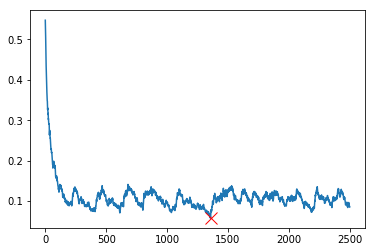

In [6]:
model = Autoencoder()
momentum = 0.95
errors = []
moving_err = None
it_count = 2500
for it in tqdm(range(it_count)):
    inp = next(gen)
    err = model(inp)
    moving_err = momentum * moving_err + err * (1. - momentum) if moving_err else err
    errors.append(moving_err)
    #print("EPOCH {} MSE {}".format(it, moving_err))

x = np.arange(it_count)
plt.plot(x, np.array(errors))
idx = np.argmin(errors)
print("BEST ERROR {}".format(errors[idx]))
plt.plot(x[idx], errors[idx], 'rx--', linewidth=2, markersize=12)
plt.show()

In [ ]:
model = Autoencoder()
momentum = 0.95
epochs = 5
errors=[]
for epoch in range(epochs):
    moving_err = None
    for it in tqdm(range(dataset_size)):
        inp = next(gen2)
        err = model(inp)
        moving_err = momentum * moving_err + err * (1. - momentum) if moving_err else err
    errors.append(moving_err)
    print("EPOCH {} MSE {}".format(epoch, moving_err))

x = np.arange(epochs)
plt.plot(x, np.array(errors))
idx = np.argmin(errors)
print("BEST ERROR {}".format(errors[idx]))
plt.plot(x[idx], errors[idx], 'rx--', linewidth=2, markersize=12)
plt.show()

 37%|███▋      | 6338/17125 [00:14<00:24, 435.63it/s]


 75%|███████▍  | 12761/17125 [00:29<00:10, 419.21it/s]


  0%|          | 10/17125 [00:00<02:56, 96.78it/s]

EPOCH 0 MSE 0.16651763875332803


  0%|          | 11/17125 [00:00<02:49, 101.09it/s]

EPOCH 1 MSE 0.31704319409048476


  0%|          | 9/17125 [00:00<03:11, 89.39it/s]

EPOCH 2 MSE 0.27757750405026516


 73%|███████▎  | 12536/17125 [01:59<00:43, 106.11it/s]